<a href="https://colab.research.google.com/github/swathy-z9q/OCRLogic/blob/master/skew_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
def rotateImage(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2) #image centre
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # new dimensions rotated image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    return cv2.warpAffine(image, M, (nW, nH),borderValue=(255,255,255))

In [3]:
os.listdir()

['.config', 'Motion_New5.jpg', 'sample_data']

In [4]:
image  = cv2.imread('Motion_New5.jpg')

In [309]:
skewedImage = rotateImage(image,20)
cv2.imwrite('skewedImage.jpg',skewedImage)

True

In [310]:
from scipy import stats
def remove_horizontal_and_small_noise(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    # Remove small dots and horizontal line
    edged = cv2.Canny(gray, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        if contour.size >= 1000:
            x, y, w, h = cv2.boundingRect(contour)
            if h < 30 or w < 30:
                cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 255), -1)
        elif contour.size < 100:
            x, y, w, h = cv2.boundingRect(contour)
            if stats.mode(gray[y:y+h, x:x+w].flatten())[0][0] > 127:
                cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 255), -1)
        elif contour.size < 25:
            cv2.rectangle(image, (x, y), (x+w+2, y+h+2), (255, 255, 255), -1)
    # Create structure element for extracting horizontal lines through morphology operations
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    # horizontalStructure = np.ones((5,5), np.uint8) 
    # Apply morphology operations
    gray = cv2.erode(image, horizontalStructure, iterations=1)
    edged = cv2.Canny(gray, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        if contour.size >= 300:
            x, y, w, h = cv2.boundingRect(contour)
            if h < 15:
                cv2.rectangle(image, (x, y), (x+w, y+h), (255, 255, 255), -1)

    return image

In [311]:
def removeIslandNoise(image):
    img_bw = 255*(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                  > 5).astype('uint8')
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    mask = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

    mask = np.dstack([mask, mask, mask]) / 255
    output = image * mask

    return output

In [312]:
skewImage = remove_horizontal_and_small_noise(skewedImage)
skewImage = removeIslandNoise(skewImage)
cv2.imwrite('noiseremoved.jpg',skewImage)

True

##1.Binarization of Image by otsu method

In [313]:

image_gray = cv2.cvtColor(skewedImage, cv2.COLOR_BGR2GRAY)
binaryImage = cv2.threshold(image_gray, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cv2.imwrite('skewedImageBinary.jpg',binaryImage)

True

##3.Identifying ccs from image

In [314]:
skewimgpreview = skewImage.copy()
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(binaryImage), connectivity=8)

for i in range(0, nb_components):
    x_min = stats[i, 0]
    y_min = stats[i, 1]
    x_max = stats[i, 0] + stats[i, 2]
    y_max = stats[i, 1] + stats[i, 3]

    cv2.rectangle(skewimgpreview, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
cv2.imwrite('output.jpg',skewimgpreview)

True

In [315]:
cv2.imwrite('outputbinary.jpg',binaryImage) 

True

In [15]:
#Erosion dilation to join vertically
#kernel = np.ones((1,2), np.uint8)
#eroded = cv2.erode(binaryImage,kernel,iterations = 1)
#dilated = cv2.dilate(eroded,kernel,iterations = 1)
#cv2.imwrite('outputbinary.jpg',dilated) 

##4.Removing dots or colon dots by filtering bounding box with less than 25 pixels

In [316]:
skewimgpreview = skewImage.copy()
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(binaryImage), connectivity=8)

font = cv2.FONT_HERSHEY_SIMPLEX 
org = (00, 185) 
fontScale = 1
color = (0, 0, 255) 
thickness = 2

for i in range(0, nb_components):
    x_min = stats[i, 0]
    y_min = stats[i, 1]
    x_max = stats[i, 0] + stats[i, 2]
    y_max = stats[i, 1] + stats[i, 3]
    #Less than 25 pixels should be removed
    #Bmax = (Wave × Have) × 4
    #Bmin = (Wave × Have) × 0.25
    if abs(y_max - y_min) > 25: #Noise removal from ccs
      text = str(y_max - y_min)
      cv2.putText(skewimgpreview, text,(x_min, y_min), font, fontScale,color, thickness)
      cv2.rectangle(skewimgpreview, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
cv2.imwrite('output.jpg',skewimgpreview)

True

##5.Bmax and Bmin set thresholds for the size-based filtering - non-text CCs filtering


*   Wave-->mean width value of all bounding box of ccs
*   Have-->mean Height value of all bounding box of ccs




```
Bmax = (Wave × Have) × 4
Bmin = (Wave × Have) × 0.25
```



In [317]:
skewimgpreview = skewImage.copy()
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(binaryImage), connectivity=8)
widths = []
heights = []
font = cv2.FONT_HERSHEY_SIMPLEX 
org = (00, 185) 
fontScale = 1
color = (0, 0, 255) 
thickness = 2
for i in range(0, nb_components):
    x_min = stats[i, 0]
    y_min = stats[i, 1]
    x_max = stats[i, 0] + stats[i, 2]
    y_max = stats[i, 1] + stats[i, 3]
    if abs(y_max - y_min) > 25: #Noise removal from ccs
      widths.append(abs(x_max-x_min))
      heights.append(abs(y_max-y_min))
      #text = str(x_max - x_min)
      #cv2.putText(skewimgpreview, text,(x_min, y_min), font, fontScale,color, thickness)
      cv2.rectangle(skewimgpreview, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
Have = np.mean(heights)
Wave = np.mean(widths)
cv2.imwrite('output.jpg',skewimgpreview)
print('Average Width',Wave)
print('Average Height',Have)
Bmax = (Wave * Have) * 4
Bmin = (Wave * Have) * 0.25
print('Bmax---->',Bmax,'   Bmin---->',Bmin)

Average Width 36.04971447766208
Average Height 46.02519314746389
Bmax----> 6636.7802869812895    Bmin----> 414.7987679363306


In [318]:
skewimgpreview = skewImage.copy()
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(binaryImage), connectivity=8)
widths = []
heights = []
font = cv2.FONT_HERSHEY_SIMPLEX 
org = (00, 185) 
fontScale = 1
color = (0, 0, 255) 
thickness = 2
for i in range(0, nb_components):
    x_min = stats[i, 0]
    y_min = stats[i, 1]
    x_max = stats[i, 0] + stats[i, 2]
    y_max = stats[i, 1] + stats[i, 3]
    
    if abs(y_max - y_min) > 25 and (Bmax > (abs(x_max-x_min) * abs(y_max-y_min)) > Bmin) : #Noise removal from ccs
      widths.append(abs(x_max-x_min))
      heights.append(abs(y_max-y_min))
      #text = str(x_max - x_min)
      #cv2.putText(skewimgpreview, text,(x_min, y_min), font, fontScale,color, thickness)
      cv2.rectangle(skewimgpreview, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
cv2.imwrite('output.jpg',skewimgpreview)


True

##6.Removing type A and C letters
Aspect ratios to remove A and C type CCs
bounding boxes width & height w(Bi) and h(Bi).
removing CCs that violate
```
α < w(Bi)/h(Bi) < β
α and β are two constants 0.6 and 2
```

And finding out centres for all Eligible connected Components

In [319]:
skewimgpreview = skewImage.copy()
blankImage = np.zeros([6476,5084,3],dtype=np.uint8)
blankImage.fill(255)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(cv2.bitwise_not(binaryImage), connectivity=8)
widths = []
heights = []
a = 0.6
b = 2
font = cv2.FONT_HERSHEY_SIMPLEX 
org = (00, 185) 
eligibleCCs = []
fontScale = 1
color = (0, 0, 255) 
thickness = 2
for i in range(0, nb_components):
    x_min = stats[i, 0]
    y_min = stats[i, 1]
    x_max = stats[i, 0] + stats[i, 2]
    y_max = stats[i, 1] + stats[i, 3]
    y_centre = int(abs(y_max - y_min)/2 + y_min)
    x_centre = int(abs(x_max - x_min)/2 + x_min)
    if abs(y_max - y_min) > 25 and (Bmax > (abs(x_max-x_min) * abs(y_max-y_min)) > Bmin) and a < abs(x_max-x_min)/abs(y_max-y_min) < b: 
      eligibleCCs.append((x_min,y_min,x_max,y_max,x_centre,y_centre))
      cv2.rectangle(skewimgpreview, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
      cv2.circle(blankImage, (x_centre,y_centre), 5, (0, 0, 255) , -1) 
cv2.imwrite('outputWithCentre.jpg',blankImage)
cv2.imwrite('finalACRemovedLetters.jpg',skewimgpreview)

True

##randomly select two ECCs of a document to calculate its slope, and put the
##resulting slope into a histogram. Then, we repeat the centers selection and slope calculation until
##the number of selections reaches a predefined threshold. Generally, the peak of histogram gives the
##slope of skew document. Considering that some documents with a small number of ECCs need
##repeated centers selection to increase the accuracy of the results

In [320]:
eligibleCCs = np.array(eligibleCCs)
eligibleCCs[:5]

array([[2248,  413, 2300,  468, 2274,  440],
       [2358,  453, 2413,  509, 2385,  481],
       [2412,  470, 2469,  534, 2440,  502],
       [2492,  482, 2560,  552, 2526,  517],
       [2140,  532, 2189,  585, 2164,  558]])

##7.Randomly selecting two ECCs and calculating slope
![alt text](https://cls.syr.edu/mathtuneup/grapha/Unit4/UnitFour/Four5.GIF)


  if abs(eccs[0][0] - eccs[1][0]) < 500:
    return eccs[0],eccs[1]
  else:

In [321]:
def random_ecc_sample(arr: np.array, size: int = 2):
  eccs = arr[np.random.choice(len(arr), size=size, replace=False)]
  return eccs[0],eccs[1] 

In [322]:
len(eligibleCCs)

2288

In [323]:
def calculateSlope(ecc1,ecc2):
  x1,x2,y1,y2 = ecc1[-2],ecc2[-2],ecc1[-1],ecc2[-1]
  if x2 - x1 != 0:
    return (y2 - y1)/(x2-x1)

In [324]:
slopeVals = []
for i in range(0,8*len(eligibleCCs)):
  ecc1,ecc2 = random_ecc_sample(eligibleCCs)
  slope = calculateSlope(ecc1,ecc2)
  if slope != None :
    slopeVals.append(round(slope,2))

In [325]:
slopeVals = np.array(slopeVals)
hist,bins = np.histogram(slopeVals)
bins

array([-1668. , -1271.5,  -875. ,  -478.5,   -82. ,   314.5,   711. ,
        1107.5,  1504. ,  1900.5,  2297. ])

In [326]:
t_slopes =  pd.Series(slopeVals).value_counts().sort_values(ascending= False).index[:3]
t_slopes

Float64Index([0.36, 0.37, 0.04], dtype='float64')

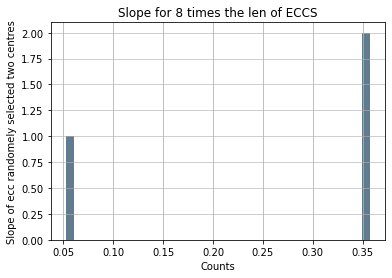

In [327]:
pd.Series(t_slopes).plot.hist(grid=True, rwidth=0.25,color='#607c8e')
plt.title('Slope for 8 times the len of ECCS')
plt.xlabel('Counts')
plt.ylabel('Slope of ecc randomely selected two centres')
plt.grid(axis='y', alpha=0.75)

##Algorithm: to find the optimal skew angle value.

##1. Find the difference between the maximum value and the minimum value Range.
##Range = S5 − S2
##Gap = |S5 − S3|
##Step 4: Calculate the experiment Q value (Qexp).
Qexp =
Gap
Range =
|S5 − S3|
S5 − S2

In [328]:
Q90 = [0.941, 0.765, 0.642, 0.56, 0.507, 0.468, 0.437,
       0.412, 0.392, 0.376, 0.361, 0.349, 0.338, 0.329,
       0.32, 0.313, 0.306, 0.3, 0.295, 0.29, 0.285, 0.281,
       0.277, 0.273, 0.269, 0.266, 0.263, 0.26
      ]
q99 = [0.994, 0.926, 0.821, 0.74, 0.68, 0.634, 0.598, 0.568,
       0.542, 0.522, 0.503, 0.488, 0.475, 0.463, 0.452, 0.442,
       0.433, 0.425, 0.418, 0.411, 0.404, 0.399, 0.393, 0.388,
       0.384, 0.38, 0.376, 0.372
       ]

In [329]:
def dixon_test(data, left=True, right=True, q_dict=Q90):
  sdata = sorted(data)
  Q_mindiff, Q_maxdiff = (0,0), (0,0)

  if left:
      Q_min = (sdata[1] - sdata[0])
      try:
          Q_min /= (sdata[-1] - sdata[0])
      except ZeroDivisionError:
          pass
      Q_mindiff = (Q_min - q_dict[len(data)], sdata[0])

  if right:
      Q_max = abs((sdata[-2] - sdata[-1]))
      try:
          Q_max /= abs((sdata[0] - sdata[-1]))
      except ZeroDivisionError:
          pass
      Q_maxdiff = (Q_max - q_dict[len(data)], sdata[-1])

  if not Q_mindiff[0] > 0 and not Q_maxdiff[0] > 0:
      outliers = []

  elif Q_mindiff[0] == Q_maxdiff[0]:
      outliers = [Q_mindiff[1], Q_maxdiff[1]]

  elif Q_mindiff[0] > Q_maxdiff[0]:
      outliers = [Q_mindiff[1]]

  else:
      outliers = [Q_maxdiff[1]]

  return outliers

In [ ]:
outliers = []
while(outliers != -1):  
  outliers = dixon_test(t_slopes)
  print(outliers)
  outliers = outliers if len(outliers)>0 else -1
  if outliers != -1:
    t_slopes = list(set(t_slopes) - set(outliers))
  else:
    break

In [330]:
outliers = dixon_test(t_slopes)
t_slopes = list(set(t_slopes) - set(outliers))
t_slopes

[0.36, 0.37]

In [331]:
soptimal = np.median(t_slopes)


```
θ = arctan(Soptm)X 180 / π
```



In [332]:
sa = (math.atan(soptimal) * 180 )/math.pi 
print ( (math.atan(soptimal) * 180 )/math.pi )


20.052082146098538


In [333]:
yy = rotateImage(skewedImage,-sa)
cv2.imwrite('final.jpg',yy)

True

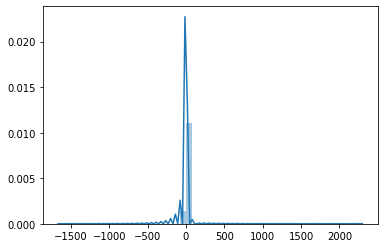

In [334]:
import seaborn as sns
sns.distplot(slopeVals)

In [294]:
def count_dist_peaks(series, bins, prominence, width):
  count, division = np.histogram(series, bins=bins)
  peaks, props = find_peaks(count, prominence=prominence, width=width)
  return peaks

In [374]:
yy = rotateImage(skewedImage,rot + 90)

True

In [118]:

def Q_Test(peakSlopes,Qcrit =   0.740):
  outliers = []
  Range =  abs(peakSlopes[0] - peakSlopes[-1])
  for i,slope in enumerate(peakSlopes):
    if(i != len(peakSlopes) - 1):
      rSlopes = set(peakSlopes) - set([slope])
      Gap = abs(slope - peakSlopes[i+1])
      Qexp = Gap/Range
      print(slope,peakSlopes[i+1],Gap,Range)
      print(Qexp)
      if Qcrit < Qexp:
        outliers.append(slope)
  return outliers


